In [1]:
#!git clone https://github.com/ArthurSSS9966/SoftHebb.git
#%cd SoftHebb

import os.path
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

# Test to load the SoftHebb package
from dataset import make_data_loaders
from model import load_layers, HebbianOptimizer, AggregateOptim
from engine import train_sup, evaluate_sup
from train import check_dimension, training_config
from utils import load_presets, load_config_dataset, CustomStepLR
from log import Log

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params = {"preset":"2SoftMlpMNIST", "dataset_sup":"MNIST", "dataset_unsup":"MNIST",
          "seed":52,"model-name":"2SoftMlpMNIST", "training_mode":"simultaneous", "training_blocks":None,
          "resume":False, "save":False}

save_location = "D:\\BlcRepo\OtherCode\\NeuroAI\\SoftHebb\\Models"


dataset_sup_config = load_config_dataset("MNIST", 0.8)
dataset_unsup_config = load_config_dataset("MNIST", 0.8)
dataset_sup_config['validation'] = True

blocks = load_presets(params["preset"])
blocks = check_dimension(blocks, dataset_sup_config)

train_config = training_config(blocks, dataset_sup_config, dataset_unsup_config, "simultaneous",
                               None)

config = train_config['t1']
train_loader, val_loader, test_loader = make_data_loaders(dataset_sup_config, config['batch_size'], device)

range = 2.165063509461097
range = 1.7320508075688772


In [7]:
def train_model(
        final_epoch: int,
        print_freq: int,
        lr: float,
        folder_name: str,
        model,
        device,
        log,
        blocks,
        learning_mode: str = 'BP'
):
    """
    Hybrid training of one model, happens during simultaneous training mode
    """
    print('\n', '********** Hybrid learning of blocks %s **********' % blocks)
    optimizer_sgd = optim.Adam(
        model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    hebbian_optimizer = HebbianOptimizer(model)
    scheduler = CustomStepLR(optimizer_sgd, final_epoch)
    optimizer = AggregateOptim((hebbian_optimizer, optimizer_sgd))
    log_batch = log.new_log_batch()
    
    train_performance = {'loss': [], 'accuracy': []}
    val_performance = {'loss': [], 'accuracy': []}
        
    for epoch in range(1, final_epoch + 1):
        measures, lr = train_sup(model, criterion, optimizer, train_loader, device, log_batch, learning_mode, blocks)

        if scheduler is not None:
            scheduler.step()

        if epoch % print_freq == 0 or epoch == final_epoch or epoch == 1:
            
            loss_test, acc_test = evaluate_sup(model, criterion, val_loader, device)
            
            log_batch = log.step(epoch, log_batch, loss_test, acc_test, lr, save=True)
            log.verbose()
            
            _, train_loss, train_acc, loss_test, acc_test = log.data[-1]
            
            train_performance['loss'].append(train_loss)
            train_performance['accuracy'].append(train_acc)
            val_performance['loss'].append(loss_test)
            val_performance['accuracy'].append(acc_test)
        
    return train_performance, val_performance

In [8]:
def plotTrainValLoss(train_performance, val_performance, name_model, total_epoch=15):

    epochs = np.arange(1, total_epoch+1, total_epoch/len(train_performance['loss']))
    
    trainloss = train_performance['loss']
    valloss = val_performance['loss']
    train_accu = train_performance['accuracy']
    val_accu = val_performance['accuracy']
    
    # Plot the loss and accuracy on the same plot with twin y-axis
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, trainloss, color='tab:red', label='Train Loss')
    ax1.plot(epochs, valloss, color='tab:blue', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc='upper left')
    ax1.set_ylim([0, 0.05])
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:green')
    ax2.plot(epochs, train_accu, color='tab:green', label='Train Accuracy')
    ax2.plot(epochs, val_accu, color='tab:orange', label='Val Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.legend(loc='upper right')
    ax2.set_ylim([60, 100])
    
    fig.tight_layout()
    plt.savefig(os.path.join(save_location, name_model, f"{name_model}_training_plot.png"))
    plt.show()


In [20]:
name_model = "2SoftMlpMNIST"
SoftHebb_model = load_layers(blocks, name_model, False)


 Model 2SoftMlpMNIST not found



 ----- Architecture Block FlattenH7841002, number 0 -----
- Flatten(start_dim=1, end_dim=-1)
- HebbSoftLinear(in_features=784, out_features=100, lebesgue_p=2,  bias=False, t_invert=12.0, bias=False, lr_bias=0.0833)
- SoftMax(t_invert=5.0, dim=1)

 ----- Architecture Block Linear(in_, number 1 -----
- Linear(in_features=100, out_features=10, bias=True)


In [17]:
log = Log(train_config)
config = train_config['t1']
total_epoch = 30

SoftHebb_loss, SoftHebb_valloss = train_model(  total_epoch,
                                                1,
                                                config['lr'],
                                                name_model,
                                                SoftHebb_model,
                                                device,
                                                log.sup['t1'],
                                                blocks=config['blocks']
                                            )
# Save the model
torch.save({'state_dict': SoftHebb_model.state_dict(),
        'config': SoftHebb_model.config}, os.path.join("D:\\BlcRepo\OtherCode\\NeuroAI\\SoftHebb\\Models", name_model, f"{name_model}.pth"))


 ********** Hybrid learning of blocks [0, 1] **********


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 1x100)

In [ ]:
plotTrainValLoss(SoftHebb_loss, SoftHebb_valloss, "2SoftMlpMNIST", total_epoch)

In [ ]:
criterion = nn.CrossEntropyLoss()
loss_test, acc_test = evaluate_sup(SoftHebb_model, criterion, test_loader, device)

print(f'Accuracy of the model on the test images: {acc_test:.2f}%')

In [24]:
name_model = "2SoftHebbCnnMNIST"
CNN_blocks = load_presets(name_model)
CNN_blocks = check_dimension(CNN_blocks, dataset_sup_config)
cnn_train_config = training_config(CNN_blocks, dataset_sup_config, dataset_unsup_config, params["training_mode"],
                                   params["training_blocks"])
SoftHebb_CNN_model = load_layers(CNN_blocks, "2SoftHebbCnnCIFAR", False)

block 0, size : 4 14 14
range = 5.0
range = 0.6185895741317419

 Model 2SoftHebbCnnCIFAR not found



 ----- Architecture Block BatchNorm2dS142(5, 5)1.0reflect, number 0 -----
- BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
- HebbSoftConv2d(1, 4, lebesgue_p=2, pruning=0, kernel_size=(5, 5), bias=False, padding_mode=reflect, t_invert=1.0, bias=False, lr_bias=0.1, activation=exp)
- Triangle(power=0.7)
- AvgPool2d(kernel_size=4, stride=2, padding=1)

 ----- Architecture Block FlattenLinear(in_, number 1 -----
- Flatten(start_dim=1, end_dim=-1)
- Linear(in_features=784, out_features=10, bias=True)


In [25]:
log = Log(cnn_train_config)
config = cnn_train_config['t1']
total_epoch = 30

CnnHebb_loss, CnnHebb_valloss = train_model(
                                            total_epoch,
                                            1,
                                            0.001,
                                            name_model,
                                            SoftHebb_CNN_model,
                                            device,
                                            log.sup['t1'],
                                            blocks=config['blocks']
                                        )

# Save the model
torch.save({'state_dict': SoftHebb_CNN_model.state_dict(),
        'config': SoftHebb_CNN_model.config}, os.path.join("D:\\BlcRepo\OtherCode\\NeuroAI\\SoftHebb\\Models", "2SoftHebbCnnMNIST", f"2SoftHebbCnnMNIST.pth"))


 ********** Hybrid learning of blocks [0, 1] **********
Epoch: [1/100]	lr: 1.00e-03	time: 00:00:09	Loss_train 0.00841	Acc_train 85.72	/	Loss_test 0.00492	Acc_test 91.54
Epoch: [2/100]	lr: 1.00e-03	time: 00:00:18	Loss_train 0.00486	Acc_train 91.09	/	Loss_test 0.00475	Acc_test 91.41
Epoch: [3/100]	lr: 1.00e-03	time: 00:00:29	Loss_train 0.00475	Acc_train 91.00	/	Loss_test 0.00412	Acc_test 92.51
Epoch: [4/100]	lr: 1.00e-03	time: 00:00:37	Loss_train 0.00427	Acc_train 91.98	/	Loss_test 0.00388	Acc_test 92.24
Epoch: [5/100]	lr: 1.00e-03	time: 00:00:48	Loss_train 0.00396	Acc_train 92.50	/	Loss_test 0.00340	Acc_test 93.82
Epoch: [6/100]	lr: 1.00e-03	time: 00:00:58	Loss_train 0.00379	Acc_train 92.88	/	Loss_test 0.00335	Acc_test 93.89
Epoch: [7/100]	lr: 1.00e-03	time: 00:01:10	Loss_train 0.00361	Acc_train 93.23	/	Loss_test 0.00335	Acc_test 93.84
Epoch: [8/100]	lr: 1.00e-03	time: 00:01:20	Loss_train 0.00349	Acc_train 93.37	/	Loss_test 0.00314	Acc_test 94.14
Epoch: [9/100]	lr: 1.00e-03	time: 00:01

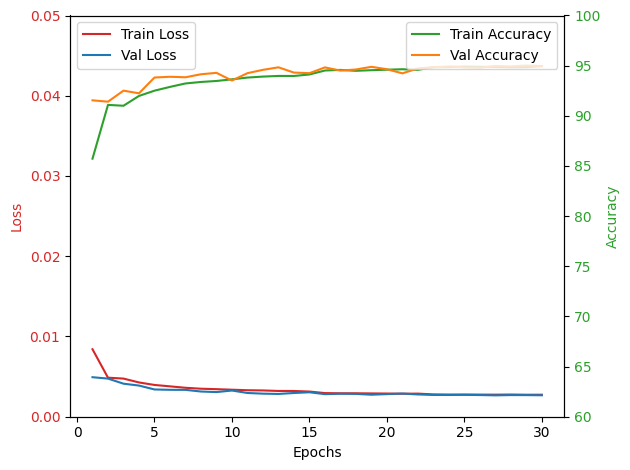

In [26]:
plotTrainValLoss(CnnHebb_loss, CnnHebb_valloss, name_model, total_epoch)

In [27]:
criterion = nn.CrossEntropyLoss()
loss_test, acc_test = evaluate_sup(SoftHebb_CNN_model, criterion, test_loader, device)

print(f'Accuracy of the model on the test images: {acc_test:.2f}%')

Accuracy of the model on the test images: 95.14%


In [ ]:
# ## Examples of how to load pre-trained models
# 
# # Load the model
# from model import MultiLayer
# 
# SoftMNIST = torch.load("D:\\BlcRepo\OtherCode\\NeuroAI\\SoftHebb\\Models\\2SoftMlpMNIST\\2SoftMlpMNIST.pth")
# 
# SoftMNIST_Model = MultiLayer(SoftMNIST['config'])
# SoftMNIST_Model.load_state_dict(SoftMNIST['state_dict'])
# 
# SoftMNIST_Model.eval()